# Pilot Study  
  
In order to evaluate the effect of global clinical trial pathway (GCT) on the post-market safety events (PMSE), this pilot study uses propensity score matching (PSM) and cox proportional hazard model (Cox). PSM classifies GCT/others with covatiates (i.e. Lag, JStudysize, Orphan, Biologic, ATC and Followup). Cox shows the association with GCT and PMSE.  


## Preprocessing
  

In [69]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set_palette('pastel')

In [70]:
# import dataset
pilot = pd.read_csv('pilot_study.csv',
                    encoding='cp932',
                    parse_dates = [1])

pilot.head(5)

,Ingredient,Approval_date,GCT,Lag,JStudysize,Orphan,Biologic,FIC,ATC,Event,TimetoEvent,Followup
0,コラゲナーゼ（クロストリジウム ヒストリチクム）,2015-07-03,0,1977.0,102,0,0,1,M,0,1621,4.44
1,スクロオキシ水酸化鉄,2015-09-28,0,670.0,494,0,0,0,V,0,1534,4.20
2,ルストロンボパグ,2015-09-28,0,NaN,220,0,0,1,B,0,1534,4.20
3,イロプロスト,2015-09-28,0,4395.0,49,0,0,1,B,0,1534,4.20
4,エボロクマブ（遺伝子組み換え）,2016-01-22,1,189.0,579,0,1,1,C,0,1418,3.88


In [71]:
# check missing values
pilot.isnull().sum()

Ingredient        0
Approval_date     0
GCT               0
Lag              37
JStudysize        0
Orphan            0
Biologic          0
FIC               0
ATC               0
Event             0
TimetoEvent       0
Followup          0
dtype: int64

In [72]:
# set index
pilot.set_index(['Ingredient'], inplace = True)

In [73]:
# convery days into years
pilot.Lag = pilot.Lag / 365
pilot.TimetoEvent = pilot.TimetoEvent / 365

In [74]:
# fill missing values
pilot['Lag'].fillna(1, inplace = True)
pilot['Lag'].isnull().sum()

0

In [75]:
# create a new column, which extracts the year in each Ingredient's Approval_date
import datetime
pilot['Approval_year'] = pilot.Approval_date.dt.year
pilot['Approval_year'] = pilot.Approval_year.astype('category')

pilot.Approval_year.dtype

CategoricalDtype(categories=[2011, 2012, 2013, 2014, 2015, 2016], ordered=False)

In [76]:
# drop Approval_date column
pilot.drop('Approval_date',
           axis = 1,
           inplace = True)

In [77]:
# create a new column, which categorizes ATC
def atc_cate(x) :
    if x == 'J' :
        return 'J'
    elif x == 'L' :
        return 'L'
    else :
        return 'others'

pilot['ATC'] = pilot.ATC.apply(atc_cate)
pilot.ATC.value_counts()

others    115
L          54
J          16
Name: ATC, dtype: int64

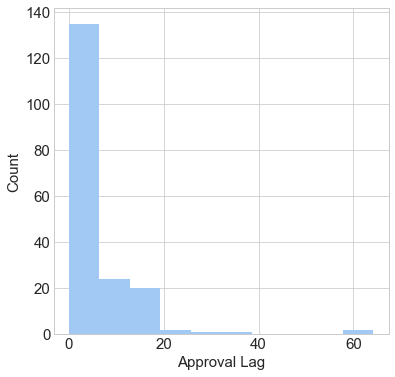

In [88]:
# check the distribution of Lag
plt.figure(figsize = (6, 6))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.Lag, bins = 10)
_ = plt.xlabel('Approval Lag')
_ = plt.ylabel('Count')

plt.show()

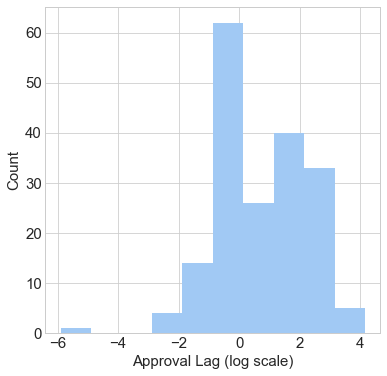

In [89]:
# convert Lag into log scale Lag
pilot['Lag_log'] = pilot.Lag.apply(np.log)

# check the distribution of Lag_log
plt.figure(figsize = (6, 6))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot.Lag_log, bins = 10)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Count')

plt.show()

In [ ]:
# stratifying Lag_log with GCT
pilot_gct = pilot.query('GCT == 1')
pilot_others = pilot.query('GCT == 0')

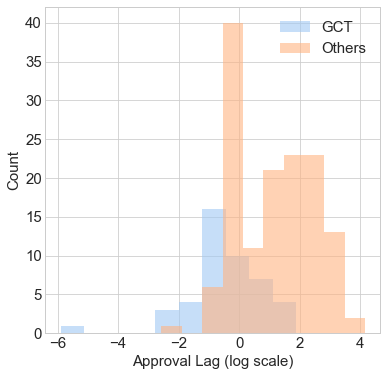

In [92]:
# check the distributions of Lag_log
plt.figure(figsize = (6, 6))
plt.rcParams["font.size"] = 15

_ = plt.hist(pilot_gct.Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.hist(pilot_others.Lag_log,
             bins = 10,
             alpha = 0.6)
_ = plt.xlabel('Approval Lag (log scale)')
_ = plt.ylabel('Count')
_ = plt.legend(['GCT', 'Others'])

plt.show()

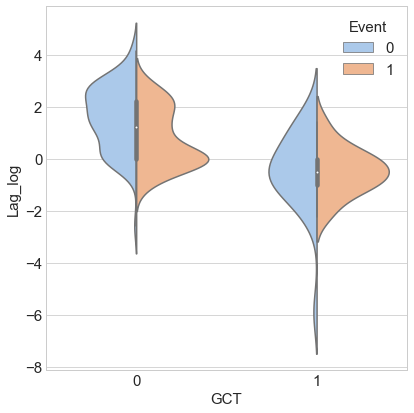

In [95]:
plt.figure(figsize = (6, 6))

ax = sns.violinplot(x='GCT',
                    y='Lag_log',
                    hue = 'Event',
                    split = True,
                    data = pilot)
plt.tight_layout()

plt.show()

In [80]:
# check dataset after modifications
pilot.head()

,GCT,Lag,JStudysize,Orphan,Biologic,FIC,ATC,Event,TimetoEvent,Followup,Approval_year,Lag_log
Ingredient,,,,,,,,,,,,
コラゲナーゼ（クロストリジウム ヒストリチクム）,0,5.416438,102,0,0,1,others,0,4.441096,4.44,2015,1.689438
スクロオキシ水酸化鉄,0,1.835616,494,0,0,0,others,0,4.202740,4.20,2015,0.607380
ルストロンボパグ,0,1.000000,220,0,0,1,others,0,4.202740,4.20,2015,0.000000
イロプロスト,0,12.041096,49,0,0,1,others,0,4.202740,4.20,2015,2.488325
エボロクマブ（遺伝子組み換え）,1,0.517808,579,0,1,1,others,0,3.884932,3.88,2016,-0.658150
